In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'

mpl.rc('font',family='serif',size='16')
fig = plt.figure(1,figsize=(7,5))
#fig = plt.figure(1,figsize=(7, 5)) ## To save figure.

tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.) 

<Figure size 504x360 with 0 Axes>

In [2]:
from scipy import special
import copy

In [3]:
def calc_S(Alpha, N_tot,Dist):
    SMatrix = np.zeros((N_tot,N_tot))
    PI = np.pi
    N  = np.int(N_tot/2)
    for r in range(N):
        for s in range(N):
            A = Alpha[r]
            B = Alpha[s]
            f1 = PI/(A+B)
            Part1 = f1*np.sqrt(f1)
            SMatrix[r,s] = Part1
    for r in range(N,N_tot):
        for s in range(N):
            A = Alpha[r]
            B = Alpha[s]
            f1 = PI/(A+B)
            Part1 = f1*np.sqrt(f1)
            Part2 = np.exp(-A*B*Dist*Dist/(A+B))
            SMatrix[r,s] = Part1*Part2
    for r in range(N):
        for s in range(N,N_tot):
            A = Alpha[r]
            B = Alpha[s]
            f1 = PI/(A+B)
            Part1 = f1*np.sqrt(f1)
            Part2 = np.exp(-A*B*Dist*Dist/(A+B))
            SMatrix[r,s] = Part1*Part2
    for r in range(N,N_tot):
        for s in range(N,N_tot):
            A = Alpha[r]
            B = Alpha[s]
            f1 = PI/(A+B)
            Part1 = f1*np.sqrt(f1)
            SMatrix[r,s] = Part1

    return SMatrix

def BuildH(Alpha,N_tot,Dist,SMatrix,F):
    PI = np.pi
    N = 4
    HMatrix = np.zeros((N_tot,N_tot))
    for R in range(N):
        for S in range(R):
            A = Alpha[R]
            B = Alpha[S]
            ### CalcKinet11 and Kinet12
            Kinet11, Kinet12 = Kinet(A, B, SMatrix[R+N, S],Dist)
            ### Calc Coul11 and Coul12
            Coul11, Coul12   = Coul(A, B, SMatrix[R+N, S],Dist,F)
            
            HMatrix[R,S]     = Kinet11+Coul11
            HMatrix[R+N,S+N] = HMatrix[R,S]
            HMatrix[R+N,S]   = Kinet12+Coul12
            HMatrix[S+N,R]   = HMatrix[R+N,S]
            
            HMatrix[S,R]     = HMatrix[R,S]
            HMatrix[S+N,R+N] = HMatrix[R+N,S+N]
            HMatrix[S,R+N]   = HMatrix[R+N,S]
            HMatrix[R,S+N]   = HMatrix[S+N,R]
            
        A = Alpha[R]
        B = A
        ### CalcKinet11 and Kinet12
        Kinet11, Kinet12 = Kinet(A, B, SMatrix[R+N, R],Dist)
        ### Calc Coul11 and Coul12
        Coul11, Coul12   = Coul(A, B, SMatrix[R+N, R],Dist,F)

        HMatrix[R,R] = Kinet11+Coul11
        HMatrix[R+N,R+N] = HMatrix[R,R]
        HMatrix[R+N,R] = Kinet12+Coul12
        
        HMatrix[R,R+N] = HMatrix[R+N,R]

    return HMatrix
                                 
def Kinet (A, B, SElem,Dist):
    PI = np.pi
    K0 = A*B/(A+B)
    Kinet11 = 3*K0*(PI/(A+B))**1.5E0
    Kinet12 = K0*(3-2*K0*Dist*Dist)*SElem
    return Kinet11, Kinet12

def Coul (A, B, SElem, Dist,F):
    PI = np.pi
    K0 = PI/(A+B)
    t = (A+B)*Dist*Dist
    Coul11 = -2*K0*(1+F(t))

    K1 = SElem/np.sqrt(K0)
    t1 = A*A*Dist*Dist/(A+B)
    t2 = B*B*Dist*Dist/(A+B)
    Coul12 = -2*K1*(F(t1)+F(t2))
    return Coul11, Coul12

def F(x):
    eps = 1.0E-10
    FFac=0.88622693E0
    
    if (np.abs(x)<eps):
        F = 1.0E0
    else:
        F = FFac*special.erf(np.sqrt(x))/np.sqrt(x)
    return F

def BuildD(SMatrix,N_tot,C):
    DensMat = np.zeros((N_tot, N_tot))
    Norm = 0.0E0
    for R in range(N_tot):
        for S in range(R):
            DensMat[R, S] = 2.0E0*C[R]*C[S]
            Norm = Norm + DensMat[R,S]*SMatrix[R,S]

        DensMat[R,R] = 2.0E0*C[R]*C[R]
        Norm = Norm + 0.50E0*DensMat[R,R]*SMatrix[R,R]

    Norm = 1.0E0/Norm
    for R in range(N_tot):
        for S in range(R+1):
            DensMat[R,S] = DensMat[R,S]*Norm
            DensMat[S,R] = DensMat[R,S]
            
    return DensMat



def BuildG(N_tot,DensMat0,QMatrix):
    DensMat = copy.deepcopy(DensMat0)
    GMatrix = np.zeros((N_tot, N_tot))

    for R in range(N_tot):
        for S in range(R+1):
            GMatrix[R,S] = 0.0E0
            for T in range(N_tot):
                for U in range(T):
                    GMatrix[R, S] = GMatrix[R,S] + DensMat[T,U]*(QMatrix[R,S,T,U])
                GMatrix[R, S] = GMatrix[R,S] +   0.5E0*DensMat[T,T]*QMatrix[R,S,T,T]
    for R in range(N_tot):
        for S in range(R+1):
            GMatrix[S,R] = GMatrix[R,S]

    return GMatrix

def CalcFockMatrix(HMatrix,GMatrix,N_tot):
    FMatrix=np.zeros((N_tot,N_tot))
    for R in range(N_tot):
        # for S in range(R+1):
        for S in range(N_tot):
            FMatrix[R,S] = HMatrix[R,S] + GMatrix[R,S]
        # FMatrix[S,R] = FMatrix[R,S]
    return FMatrix

def BuildQ(N_tot,Dist,SMatrix,F):
    PI = np.pi
    QMatrix = np.zeros((N_tot,N_tot,N_tot,N_tot))
    for R in range(N_tot):
        for S in range(R+1):
            for T in range(R+1):
                if (T < R):
                    MaxU = T + 1
                else:
                    MaxU = S + 1
                for U in range(MaxU):
                    A = Alpha[R]
                    B = Alpha[S]
                    CC = Alpha[T]
                    D = Alpha[U]
                    P1 = A+B
                    P2 = CC+D
                    P3 = P1+P2
                    P = ((2*(np.int((R)/4))-1)*A +(2*(np.int((S)/4))-1)*B)/(A+B)*Dist/2
                    Q = ((2*(np.int((T)/4))-1)*CC+(2*(np.int((U)/4))-1)*D)/(CC+D)*Dist/2
                    #print ("%4d %4d %4d %4d %8.3f %8.3f" % (R,S,T,U,P,Q))
                    tt = (P1*P2/P3)*(P-Q)**2
                    Lambda = 2*np.sqrt(P1*P2/(PI*P3))
                    G = F(tt)
                    MatElem = SMatrix[R,S]*SMatrix[T,U]*Lambda*G
                    QMatrix[R,S,T,U] = MatElem
                    QMatrix[R,S,U,T] = MatElem
                    QMatrix[T,U,R,S] = MatElem
                    QMatrix[T,U,S,R] = MatElem
    return QMatrix

$$\begin{aligned}
\boldsymbol{\rm{P}}_{pq} & = \frac{2CC^{\rm{T}}}{C^{\rm{T}}\boldsymbol{S}C} \\
\boldsymbol{\rm{F}}_{pq} & = \boldsymbol{\rm{H}}_{pq} + \boldsymbol{\rm{G}}_{pq} = \boldsymbol{\rm{H}}_{pq}+\sum_{rs}\boldsymbol{\rm{P}}_{rs}(\boldsymbol{\rm{Q}}_{prqs}-\frac{1}{2}\boldsymbol{\rm{Q}}_{prsq}) \\
E & = \sum_{p,q}\boldsymbol{\rm{P}}_{pq}\left[\boldsymbol{\rm{H}}_{pq}+\frac{1}{2}\boldsymbol{\rm{G}}_{pq} \right] = \sum_{p,q}\boldsymbol{\rm{P}}_{pq}\left[\frac{1}{2} \boldsymbol{\rm{H}}_{pq}+\frac{1}{2}(\boldsymbol{\rm{H}}_{pq}+\boldsymbol{\rm{G}}_{pq}) \right] \\
& = \frac{1}{2} \sum_{p,q} \boldsymbol{\rm{P}}_{pq}\left[
\boldsymbol{\rm{H}}_{pq} + \boldsymbol{\rm{F}}_{pq} 
\right] \\
\end{aligned}$$

In [4]:
def DiagFock(S,N_tot,Fock,D,V,Vd,i_fact,Dist,H):

    tmp = np.dot(Fock,V) 
    H_prime = np.dot(Vd,tmp)

    EE, C_prime = np.linalg.eigh(H_prime)

    C = np.dot(V,C_prime)
    C_use = copy.deepcopy(C[:,0])
    D_new = BuildD(S, N_tot, C_use) 

    Ener = 0.0E0
    for i in range(N_tot):
        for j in range(i):
            Ener += D_new[i,j]*(H[i,j]+Fock[i,j])
        Ener += 0.5*D_new[i,i]*(H[i,i]+Fock[i,i])
    
    return Ener, D_new

In [5]:
import sys,os

In [32]:
Alpha=np.array([13.00773E0,1.962079E0,0.444529E0,0.1219492E0,
       13.00773E0,1.962079E0,0.444529E0,0.1219492E0],dtype=float)
N_tot = 8

C0=np.zeros(N_tot)
for i in range(N_tot):
    C0[i] = 1.0E0
    

Dist0 = 1.0E0 - 0.36E0
incr = 0.02
D_traj = []
E_traj = []
for i in range(400):
    Dist = Dist0 + incr*i
    S = calc_S(Alpha,N_tot,Dist)

    D = BuildD(S,N_tot,C0)
    D_new = copy.deepcopy(D)
    H = BuildH(Alpha,N_tot,Dist,S,F)
    small_S, U = np.linalg.eigh(S)
    half_S = np.zeros((N_tot,N_tot))
    for i in range(N_tot):
        half_S[i,i] = 1.0E0/np.sqrt(np.abs(small_S[i]))
    V = np.dot(U,half_S)
    Vd = np.transpose(V)
    Q = BuildQ(N_tot,Dist,S,F)
    
    Ener_old = 0.0E0
    for j in range(400):
        D = copy.deepcopy(D_new)
        G = BuildG(N_tot,D,Q)
        Fock = CalcFockMatrix(H,G,N_tot)
        Ener, D_new = DiagFock(S,N_tot,Fock,D,V,Vd,j,Dist,H)
        DeltaD= np.subtract(D_new,D)
        errD  = np.linalg.norm(DeltaD,ord='fro')
        # print (i+1, errD)
        if np.abs(Ener-Ener_old)<1.0E-8 and errD<1.0E-9:
            print(j+1, Ener, errD)
            if_save= True
            break
        elif j==800-1:
            print(j+1,"No convergence!")
            if_save = False
            
        Ener_old = Ener
    # print(" %8.3f %12.6f" % (Dist, Ener + 1/Dist))
    if if_save:
        D_traj.append(Dist)
        E_traj.append(Ener+1/Dist)

17 -2.355516496138058 6.131470598337666e-10
17 -2.338460436080273 5.817392719751445e-10
17 -2.321597349501733 5.510967115736439e-10
17 -2.304929255049326 5.211673982485147e-10
17 -2.288457605881427 4.919366586956979e-10
17 -2.272183400963529 4.633993212786904e-10
17 -2.2561072674913922 4.3558237976866314e-10
17 -2.2402295217167896 4.085238107824251e-10
17 -2.2245502144864413 3.8227149649948045e-10
17 -2.20906916640997 3.568792601133817e-10
17 -2.193785996130822 3.3241043570458517e-10
17 -2.178700143912705 3.089146555837947e-10
17 -2.163810891779091 2.864487328574864e-10
16 -2.149117380071015 9.79382338551456e-10
16 -2.134618624874097 9.077052269217713e-10
16 -2.120313525512058 8.397805417326568e-10
16 -2.1062008766905995 7.756674790369364e-10
16 -2.0922793743002446 7.153869409204358e-10
16 -2.0785476195744383 6.589226712021402e-10
16 -2.0650041211953 6.062263325186019e-10
16 -2.0516472958081415 5.572129037984431e-10
16 -2.038475467477863 5.117732987063367e-10
16 -2.0254868666456187 4.6

KeyboardInterrupt: 

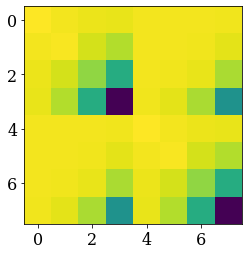

In [7]:
plt.imshow(H)
plt.show()

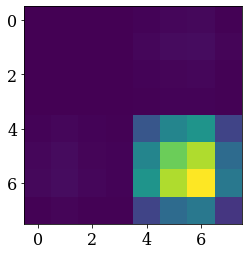

In [42]:
plt.imshow(D_new)
plt.show()

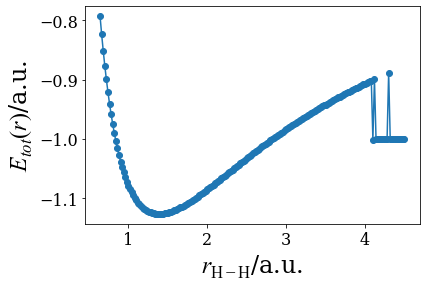

In [41]:
plt.plot(D_traj,E_traj,'o-')
plt.xlabel(r"$r_{\rm{H-H}}$/a.u.",fontsize=24)
plt.ylabel(r"$E_{tot}(r)$/a.u.",fontsize=24)
plt.show()

In [51]:
print(len(a))
print(a[172,1]+xx[172],D_traj[172])
print(a[173,1]+xx[173],D_traj[173])
print(a[174,1]+xx[174],D_traj[174])


175
-0.9016328393366209 4.08
-0.8979776658339229 4.1
-0.8783273776157313 4.12


175 175


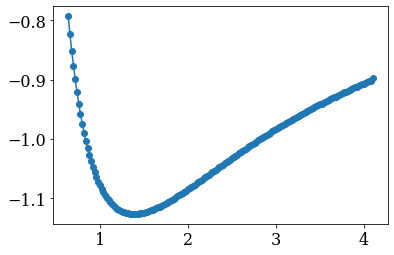

In [5]:
a = np.genfromtxt('tmp.dat')
xx = np.divide(1.0,D_traj)
print(len(a),len(xx[:len(a)]))
plt.plot(D_traj[:len(a)-1],a[:-1,1]+xx[:len(a)-1],'o-')
plt.show()

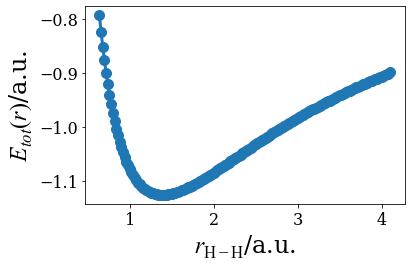

In [43]:
plt.plot(D_traj[:len(a)-1],a[:-1,1]+xx[:len(a)-1],'o-',lw=3,markersize=10)
plt.xlabel(r"$r_{\rm{H-H}}$/a.u.",fontsize=24)
plt.ylabel(r"$E_{tot}(r)$/a.u.",fontsize=24)
figname='H2_HF_8g.png'
plt.tight_layout()
plt.savefig(figname,dpi=300,format='png')
plt.show()

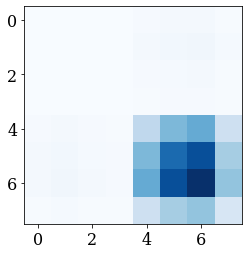

In [46]:
plt.imshow(D_new,cmap='Blues')
plt.show()

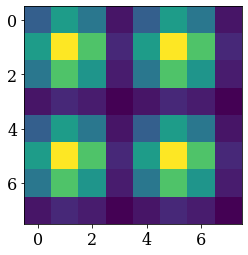

In [14]:
C = [0.0925615486, \
     0.165180118, \
     0.120122665, \
     0.0211545657,\
     0.0925615486, \
     0.165180118, \
     0.120122665, \
     0.0211545657]

DDD = BuildD(S,N_tot,C)
plt.imshow(DDD)
plt.show()

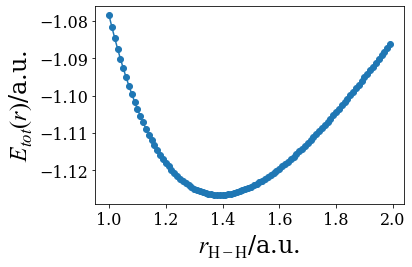

In [3]:
fpath = '/Users/yongleli/Course/Course2021/Comput_Phys_2021/Thijssen_code/ch4_b/ch4'
a = np.genfromtxt(fpath+'/e_vs_dist.dat.bak')
plt.plot(a[:,0],a[:,1],'o-')
plt.xlabel(r"$r_{\rm{H-H}}$/a.u.",fontsize=24)
plt.ylabel(r"$E_{tot}(r)$/a.u.",fontsize=24)
figname = 'H2.png'
plt.tight_layout()
plt.savefig(figname,format='png',dpi=400)
plt.show()

In [6]:
print(np.min(a[:,1]))

-2.355516496138058


In [4]:
Dist0 = 1.0E0 - 0.36E0
incr = 0.02
D_traj = []
E_traj = []
for i in range(175):
    Dist = Dist0 + incr*i
    D_traj.append(Dist)

In [2]:
pip install scipy --upgrade

     |████████████████████████████████| 55.6 MB 59.6 MB/s eta 0:00:01
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.1
    Uninstalling scipy-1.7.1:
      Successfully uninstalled scipy-1.7.1
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Morse potential fitting
# from scipy.optimize import curve_fit
from scipy import optimize as op

In [16]:


#
x_data2 = D_traj[:len(a)-1]
y_data2 = a[:-1,1]+xx[:len(a)-1]
tstart = [0.5, 1, 1.5, -0.5]
t=np.linspace(x_data2[0],x_data2[-1],1000)
def morse(x, q, m, u , v):
    return (q * (np.exp(-2*m*(x-u))-2*np.exp(-m*(x-u))) + v)

popt, pcov = op.curve_fit(morse, x_data2, y_data2, p0 = tstart,  maxfev=40000000)
print(popt) 


yfit = morse(t,popt[0], popt[1], popt[2], popt[3])





[ 0.26321812  0.92899118  1.43090488 -0.86948876]


In [18]:
print(pcov)

[[ 6.71686011e-06 -1.76868752e-05  6.84865572e-06  6.08917163e-06]
 [-1.76868752e-05  8.36923232e-05 -3.60632908e-05 -2.07202187e-05]
 [ 6.84865572e-06 -3.60632908e-05  1.94998055e-05  8.37712816e-06]
 [ 6.08917163e-06 -2.07202187e-05  8.37712816e-06  6.36229719e-06]]


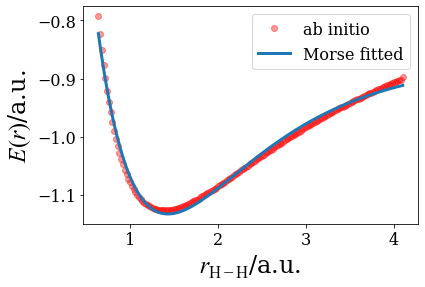

In [17]:
plt.plot(x_data2, y_data2,"ro",alpha=0.4,label="ab initio")
plt.plot(t, yfit,lw=3,label="Morse fitted")
plt.xlabel(r"$r_{\rm{H-H}}$/a.u.",fontsize=24)
plt.ylabel(r"$E(r)$/a.u.",fontsize=24)
plt.legend(loc='best')
plt.show()